In [1]:
from bs4 import BeautifulSoup as BS
from urllib.request import urlretrieve, urlopen, Request
import numpy as np
import requests

from IPython import display
from ipywidgets import widgets
from IPython.display import display, clear_output

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900'
r = requests.get(url)
html_doc = r.text
soup = BS(html_doc, 'html.parser')
for table in soup.find_all('table'):
    print (table.get('class'))

['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-multiple_issues', 'compact-ambox']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Refimprove']
['plainlinks', 'metadata', 'ambox', 'ambox-style', 'ambox-Cleanup']
['plainlinks', 'metadata', 'ambox', 'ambox-content', 'ambox-Update']
['plainlinks', 'metadata', 'ambox', 'ambox-content']
['sortable', 'wikitable']


Found the table class to reference: table class="sortable wikitable

In [3]:
#table class="sortable wikitable
#for table in soup.find_all('table'):
#    print (table.get('class'))

In [4]:
import pandas as pd 
quakes = pd.read_html(str(table),header=0)[0]
quakes.columns.values[1]= 'Country'
quakes['year'] = quakes['Origin (UTC)'].str[:4]

### strip characters
> alpha characters from Magnitude

> question marks from Lat, Long, Depth

> footnotes from Other Source and EM-DAT Deaths

In [5]:
pattern = r'\(.*\)|\[.*\]|\D'
quakes['Other Source Deaths'] = quakes['Other Source Deaths'].str.replace(pattern,"")
quakes['EM-DAT Total Deaths'] = quakes['EM-DAT Total Deaths'].str.replace(pattern,"")

mag_pattern = r'[^\.\d].*'
quakes['Magnitude'] = quakes['Magnitude'].str.replace(mag_pattern, "")

quakes['Other Source Deaths'] = pd.to_numeric(quakes['Other Source Deaths'])
quakes['EM-DAT Total Deaths'] = pd.to_numeric(quakes['EM-DAT Total Deaths'])
quakes['Magnitude'] = pd.to_numeric(quakes['Magnitude'])

In [6]:
lat_pattern = r'\?'
quakes['Lat'] = quakes['Lat'].replace(lat_pattern, np.nan, regex=True)
quakes['Long'] = quakes['Long'].replace(lat_pattern, np.nan, regex=True)
quakes['Depth (km)'] = quakes['Depth (km)'].replace(lat_pattern, np.nan, regex=True)
quakes['Lat'] = pd.to_numeric(quakes['Lat'])
quakes['Long'] = pd.to_numeric(quakes['Long'])
quakes['Depth (km)'] = pd.to_numeric(quakes['Depth (km)'])

In [7]:
quakes['Deaths'] = quakes[['PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', 'Other Source Deaths']].max(axis=1)

In [8]:
#quakes['Country']
country_pattern = r'(, ?| ?\().*'
quakes['Country'] = quakes['Country'].str.replace(country_pattern, "")

### Start GeoPandas work. Convert to Points. Map to Coordinate Reference System

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [10]:
# once cleaned Lat Long columns, ref http://jonathansoma.com/lede/foundations-2017/classes/geopandas/mapping-with-geopandas/
def make_point(row):
    return Point(row.Long, row.Lat)

points = quakes.apply(make_point, axis=1)
quakes = gpd.GeoDataFrame(quakes, geometry=points)

quakes.crs = {'init': 'epsg:4326'}

### import toolkits to control colorbar. Map geopandas dataframe on world.plot, create ipywidgets M for magnitude floatSlider and D for country Dropdown

A Jupyter Widget

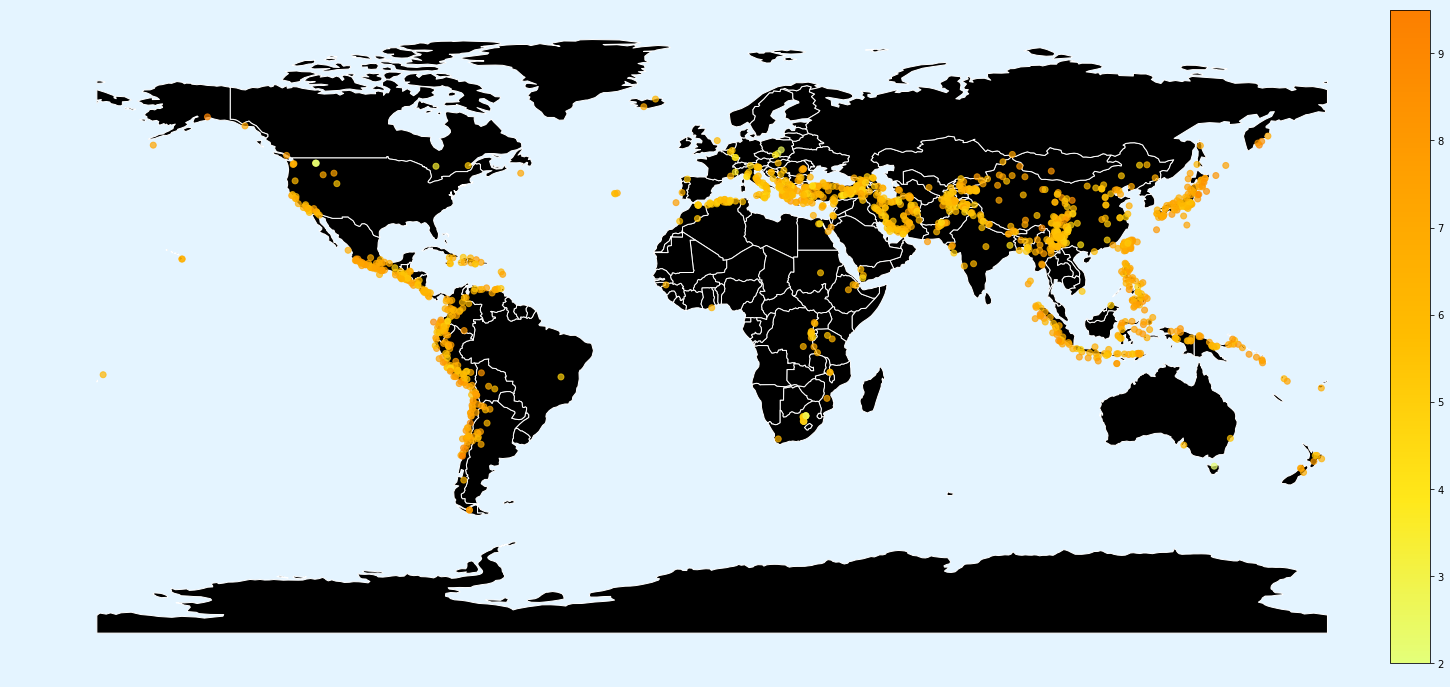

In [11]:
from mpl_toolkits.axes_grid1 import make_axes_locatable #imported for colorbar placement
#import traitlets
import warnings

## repeated below to re-display graph ##
ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
ax.axis('off')
quakes.plot(ax=ax, column='Magnitude', alpha=0.4, cmap='Wistia');
fig = ax.get_figure()
fig.patch.set_facecolor('#e4f4ff')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='3%', pad=0.01)
sm = plt.cm.ScalarMappable(cmap='Wistia', norm=plt.Normalize(vmin=2.0, vmax=10.0))
sm._A = []
fig.colorbar(sm,cax=cax)
## repeated below to re-display graph ##

country = 'ALL'
minimum = 2.0
maximum = 9.5
world_copy = world.copy()

m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=quakes['Magnitude'].min(),
    max=quakes['Magnitude'].max(),
    description='Magnitude',
    continuous_update=False,
)

countries = sorted(list(set(quakes.Country)))
countries.insert(0, 'ALL')
countries.remove("")

d = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)
z = widgets.HBox([m,d])
display(z)

def response(change):
    try:
        clear_output(wait=True)
        global country
        global maximum
        global minimum
        global world_copy
        if len(change['new']) == 2:
            maximum = change['new'][1]
            minimum = change['new'][0]
        else:
            country = change['new']
        display(z)
        if country.upper() == 'ALL':
            display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes['Magnitude'] <= maximum)]
            world_copy = world
        else:
            display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes['Magnitude'] <= maximum) & (quakes['Country'].str.upper() == country.upper())]
            world_copy = world[world['name'].str.upper() == country.upper()]
        
        ax = world_copy.plot(color='black', edgecolor='white', figsize=(25,55))
        ax.axis('off')
        display_df.plot(ax=ax, column='Magnitude', alpha=0.7, cmap='Wistia');
        fig = ax.get_figure()
        fig.patch.set_facecolor('#e4f4ff')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='3%', pad=0.01)
        sm = plt.cm.ScalarMappable(cmap='Wistia', norm=plt.Normalize(vmin=minimum, vmax=maximum)) 
        sm._A = []
        fig.colorbar(sm,cax=cax)
    except:
        print("Ain't no earthquakes of this magnitude in this country... Try again")
        warnings.filterwarnings('ignore')
            
m.observe(response, names='value')
d.observe(response, names='value')

A Jupyter Widget

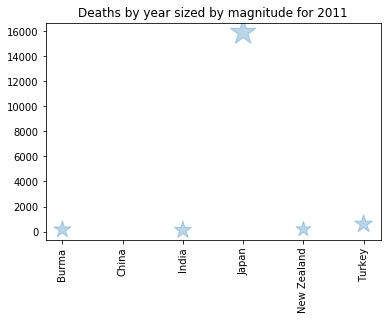

      year      Country  Magnitude   Deaths
1336  2011        Burma        6.8    150.0
1334  2011        China        5.4      NaN
1338  2011        India        6.9    111.0
1335  2011        Japan        9.0  15894.0
1337  2011        Japan        7.1      NaN
1333  2011  New Zealand        6.3    181.0
1339  2011       Turkey        7.1    601.0


In [12]:
plot_year_death = quakes.copy() #copy the original df for this specific plot
years = sorted(list(set(plot_year_death['year']))) #make unique list of years, ascending
plot_year_death = plot_year_death.loc[plot_year_death['year']==years[-1]] #years[-1] chooses most recent year for display

plt.title('Deaths by year sized by magnitude for ' + years[-1]) #display year selection in title
plt.xticks(rotation='vertical')
plt.scatter(plot_year_death['Country'], plot_year_death['Deaths'], marker='*', alpha=0.3, s=plot_year_death['Magnitude']**3, )

d_y = widgets.Dropdown(
    options=years,
    value=years[-1],  # using -1 defaults to the most recent year of unique years list
    description='Year',
    disabled=False,
)
display(d_y)
plt.show()
print(plot_year_death[['year','Country','Magnitude','Deaths']].sort_values('Country'))

def plot_y(y_change):
    clear_output()
    year = y_change['new']
    plot_year_death = quakes.copy() 
    plot_year_death = plot_year_death.loc[plot_year_death['year']==year] #new df with year selected
    display(d_y)
    plt.title('Deaths by country sized by magnitude for ' + year) #display year selection in title
    plt.xticks(rotation='vertical')
    plt.scatter(plot_year_death['Country'], plot_year_death['Deaths'], marker='*', alpha=0.3, s=plot_year_death['Magnitude']**3)
    plt.show()
    print(plot_year_death[['year','Country','Magnitude','Deaths']].sort_values('Country'))

d_y.observe(plot_y, names='value')
#2007

A Jupyter Widget

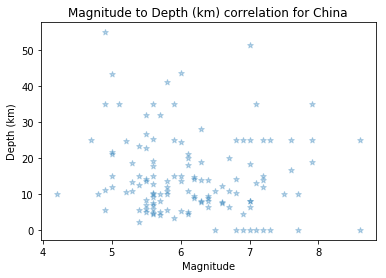

In [14]:
mag_dep = quakes.groupby(['Country','Magnitude','Depth (km)'])['Deaths'].sum()
mag_dep=mag_dep.reset_index()
mag_dep
plt.title('Magnitude to Depth (km) correlation')
plt.xlabel('Magnitude')
plt.ylabel('Depth (km)')
plt.scatter(mag_dep['Magnitude'],mag_dep['Depth (km)'], marker='*', alpha=0.3)#, s=mag_dep['Deaths'])

d_c = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)
display(d_c)

def plot_d(c_change):
    clear_output()
    country = c_change['new']
    plot_mag_dep = mag_dep.copy()
    test_mag_dep = mag_dep.loc[mag_dep['Country']==country]
    display(d_c)
    plt.title('Magnitude to Depth (km) correlation for ' + country)
    plt.xlabel('Magnitude')
    plt.ylabel('Depth (km)')
    plt.scatter(test_mag_dep['Magnitude'],test_mag_dep['Depth (km)'], marker='*', alpha=0.3)#, s=mag_dep['Deaths'])

d_c.observe(plot_d, names='value')
#China

A Jupyter Widget

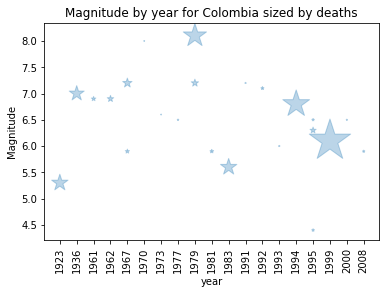

In [15]:
c_y_d = quakes.groupby(['Country','year','Magnitude'])['Deaths'].sum()
c_y_d=c_y_d.reset_index()

plt.title('Magnitude by year per country, sized by deaths')
plt.xlabel('year')
plt.xticks(rotation='vertical')
plt.ylabel('Magnitude')
plt.scatter(c_y_d['year'],c_y_d['Magnitude'], marker='*', alpha=0.3, s=c_y_d['Deaths'])

d_y_d = widgets.Dropdown(
    options=countries,
    value='ALL',
    description='Country',
    disabled=False,
)
display(d_y_d)

def plot_c_y_d(c_y_d_change):
    clear_output()
    country = c_y_d_change['new']
    c_y_d_select = c_y_d.loc[c_y_d['Country']==country]
    display(d_y_d)
    plt.title('Magnitude by year for ' + country + ' sized by deaths')
    plt.xlabel('year')
    plt.xticks(rotation='vertical')
    plt.ylabel('Magnitude')
    plt.scatter(c_y_d_select['year'],c_y_d_select['Magnitude'], marker='*', alpha=0.3, s=c_y_d_select['Deaths'])

d_y_d.observe(plot_c_y_d, names='value')
#colombia

# The break ----- above = confirmed ----- below = testing

# Working Widget: FloatSlider for Magnitude

In [16]:
### better mapping below ###

'''m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=quakes['Magnitude'].min(),
    max=quakes['Magnitude'].max(),
    description='Magnitude',
    continuous_update=False,
)
display(m)

ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
ax.axis('off')
quakes.plot(ax=ax, marker='*', color='orange', markersize=10);

def response(change):
    clear_output(wait=True)
    display(m)
    maximum = change['new'][1]
    minimum = change['new'][0]

    display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes['Magnitude'] <= maximum)]
    ax = world.plot(color='black', edgecolor='white', figsize=(25,55))
    ax.axis('off')
    display_df.plot(ax=ax, marker='*', color='orange', markersize=10);
        
m.observe(response, names='value')'''

'm = widgets.FloatRangeSlider(\n    value=(0, 15),\n    min=quakes[\'Magnitude\'].min(),\n    max=quakes[\'Magnitude\'].max(),\n    description=\'Magnitude\',\n    continuous_update=False,\n)\ndisplay(m)\n\nax = world.plot(color=\'black\', edgecolor=\'white\', figsize=(25,55))\nax.axis(\'off\')\nquakes.plot(ax=ax, marker=\'*\', color=\'orange\', markersize=10);\n\ndef response(change):\n    clear_output(wait=True)\n    display(m)\n    maximum = change[\'new\'][1]\n    minimum = change[\'new\'][0]\n\n    display_df = quakes[(quakes["Magnitude"] >= minimum) & (quakes[\'Magnitude\'] <= maximum)]\n    ax = world.plot(color=\'black\', edgecolor=\'white\', figsize=(25,55))\n    ax.axis(\'off\')\n    display_df.plot(ax=ax, marker=\'*\', color=\'orange\', markersize=10);\n        \nm.observe(response, names=\'value\')'

In [18]:
'''import ipywidgets as widgets

from IPython.display import display
m = widgets.FloatRangeSlider()
m.value = quakes['Magnitude'].max()

display(m)

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


from IPython.display import display
def f(d, m):
    display(d + m)
    return d+m

m = widgets.FloatRangeSlider(
    value=(0, 15),
    min=quakes['Magnitude'].min(),
    max=quakes['Magnitude'].max(),
    description='Magnitude',
    continuous_update=False,
)
display(m)

d = widgets.Dropdown(
    options=['coolwarm', 'seismic', 'bwr'],
    value='seismic',
    description='cmap',
    disabled=False,
)
display(d)
'''

"import ipywidgets as widgets\n\nfrom IPython.display import display\nm = widgets.FloatRangeSlider()\nm.value = quakes['Magnitude'].max()\n\ndisplay(m)\n\nfrom __future__ import print_function\nfrom ipywidgets import interact, interactive, fixed, interact_manual\nimport ipywidgets as widgets\n\n\nfrom IPython.display import display\ndef f(d, m):\n    display(d + m)\n    return d+m\n\nm = widgets.FloatRangeSlider(\n    value=(0, 15),\n    min=quakes['Magnitude'].min(),\n    max=quakes['Magnitude'].max(),\n    description='Magnitude',\n    continuous_update=False,\n)\ndisplay(m)\n\nd = widgets.Dropdown(\n    options=['coolwarm', 'seismic', 'bwr'],\n    value='seismic',\n    description='cmap',\n    disabled=False,\n)\ndisplay(d)\n"

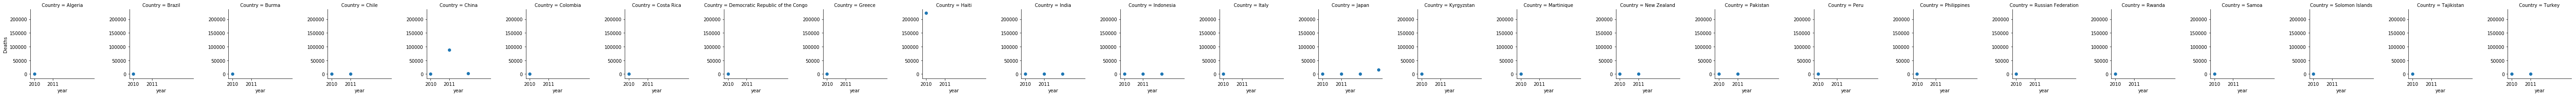

In [21]:
df_agg = quakes.groupby(['Country','year'], as_index=False)['Deaths'].sum()
#df_agg.reset_index()
df_agg = pd.DataFrame(df_agg)
df_agg.reset_index()

last5_df = df_agg.loc[df_agg['year'].isin(['2007','2008','2009','2010','2011'])]
last5_df

import seaborn as sns
plot = sns.FacetGrid(last5_df, col='Country')
#plt.xticks([2007,2008,2009,2010,2011])
plot.map(plt.scatter,'year','Deaths')

plt.show()


In [23]:
quake_by_country = quakes.groupby(['Country','year','Magnitude','Deaths'])['Country'].count


In [25]:
'''import mpld3

plot_year_death = quakes.copy()
years = sorted(list(set(plot_year_death['year'])))
plot_year_death = plot_year_death.loc[plot_year_death['year']==years[-1]]

fig, ax = plt.subplots()

plt.title('Deaths by year sized by magnitude for ' + years[-1])
plt.xticks(rotation='vertical')
scatter = ax.scatter(plot_year_death['Country'], plot_year_death['Deaths'], marker='*', alpha=0.3, s=plot_year_death['Magnitude']**2)


d = widgets.Dropdown(
    options=years,
    value=years[-1],
    description='Year',
    disabled=False,
)
display(d)

N= 100
labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.show()

def plot_y(y_change):
    clear_output()
    year = y_change['new']
    plot_year_death = quakes.copy()
    plot_year_death = plot_year_death.loc[plot_year_death['year']==year]
#    print(year)
    display(d)
    plt.title('Deaths by country sized by magnitude for ' + year)
    plt.xticks(rotation='vertical')
    plt.scatter(plot_year_death['Country'], plot_year_death['Deaths'], marker='*', alpha=0.3, s=plot_year_death['Magnitude']**3)

d.observe(plot_y, names='value')

'''

"import mpld3\n\nplot_year_death = quakes.copy()\nyears = sorted(list(set(plot_year_death['year'])))\nplot_year_death = plot_year_death.loc[plot_year_death['year']==years[-1]]\n\nfig, ax = plt.subplots()\n\nplt.title('Deaths by year sized by magnitude for ' + years[-1])\nplt.xticks(rotation='vertical')\nscatter = ax.scatter(plot_year_death['Country'], plot_year_death['Deaths'], marker='*', alpha=0.3, s=plot_year_death['Magnitude']**2)\n\n\nd = widgets.Dropdown(\n    options=years,\n    value=years[-1],\n    description='Year',\n    disabled=False,\n)\ndisplay(d)\n\nN= 100\nlabels = ['point {0}'.format(i + 1) for i in range(N)]\ntooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)\nmpld3.plugins.connect(fig, tooltip)\n\nmpld3.show()\n\ndef plot_y(y_change):\n    clear_output()\n    year = y_change['new']\n    plot_year_death = quakes.copy()\n    plot_year_death = plot_year_death.loc[plot_year_death['year']==year]\n#    print(year)\n    display(d)\n    plt.title('Deaths by c